<h1>Sentiment Classification</h1>

<h2>CNN-BiLSTM GloVe</h2>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import contractions

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import re
from nltk import pos_tag
from nltk.corpus import wordnet as wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


import tensorflow as tf
import tqdm
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, classification_report, 
    precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm


In [2]:
def wordnet_pos_code(tag):
    '''Translation from nltk tags to Wordnet code'''
    if tag.startswith('NN'):
        return wordnet.NOUN
    elif tag.startswith('VB'):
        return wordnet.VERB
    elif tag.startswith('JJ'):
        return wordnet.ADJ
    elif tag.startswith('RB'):
        return wordnet.ADV
    else:
        return None

In [3]:
#Load and parse data

train_df = pd.read_csv('//Users//datdao//Downloads//archive//train.txt', sep=";", header=None, names=['text','emotion'])
test_df = pd.read_csv('//Users//datdao//Downloads//archive//test.txt', sep=";", header=None, names=['text','emotion'])
val_df = pd.read_csv('//Users//datdao//Downloads//archive//val.txt', sep=";", header=None, names=['text','emotion'])

In [4]:
#Checking null values

train_df.info()
print()
test_df.info()
print()
val_df.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     16000 non-null  object
 1   emotion  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB



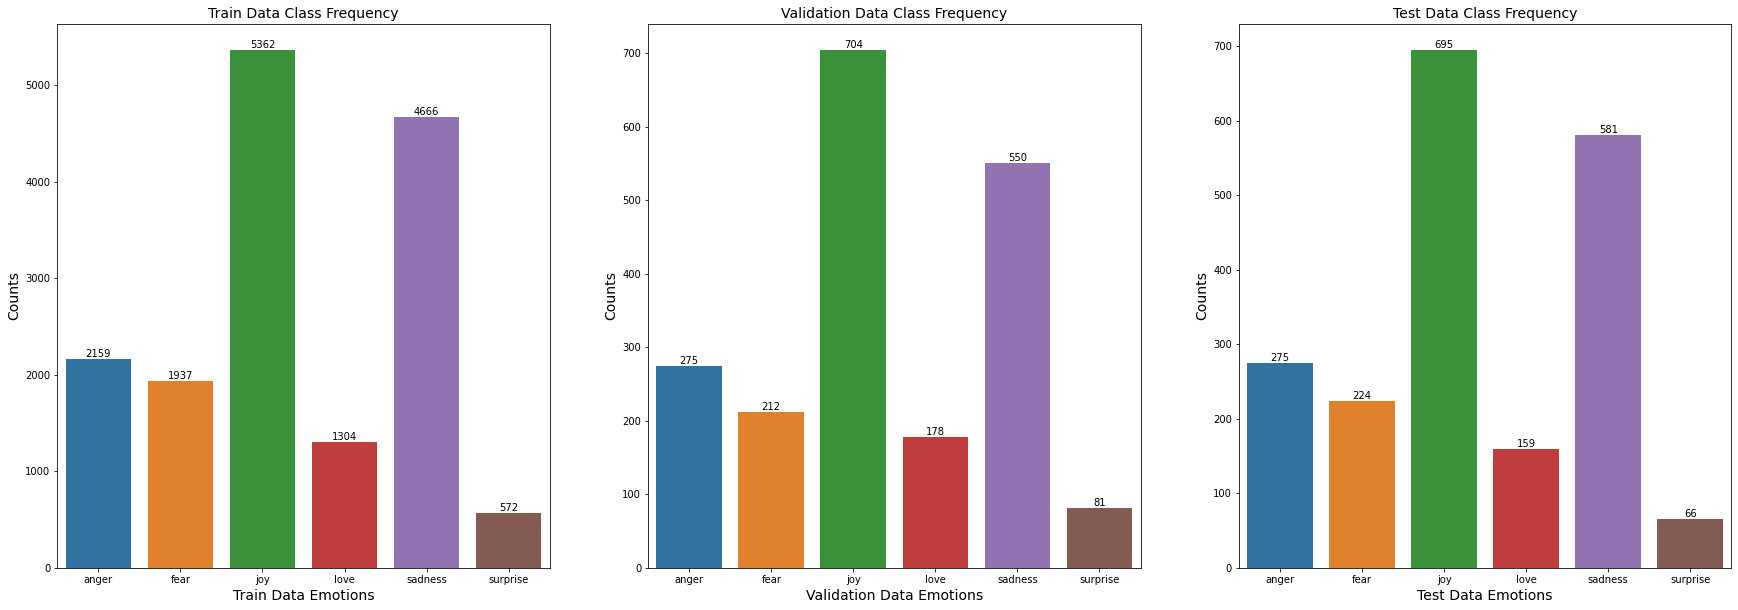

In [5]:
#Checking for distribution (data balance)

data = {'Train Data': train_df, 'Validation Data': val_df, 'Test Data': test_df}
bar, ax = plt.subplots(1,3, figsize=(30, 10))
emo_order = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

    
for index, datum in enumerate(data):
    sns.countplot(ax = ax[index],x = 'emotion', data = data[datum], order=emo_order)
    ax[index].set_title(datum +' Class Frequency', size=14)
    ax[index].set_ylabel('Counts', size=14)
    ax[index].set_xlabel(datum +' Emotions', size=14)
    ax[index].bar_label(ax[index].containers[0])
plt.show()


In [6]:
# Preprocessing: lower cases, remove non-text elements & stopwords, remove contractions, and tokenize data

lm = WordNetLemmatizer()

stoplist = ['feel', 'felt', 'feeling', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
            'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
            'she', 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
            'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is',
            'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
            'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
            'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below',
            'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
            'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
            'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will',
            'just', 'should', 'now', 'href',  'http', 'www', 'img', 'src',]


def data_prep(df):
    corpus = []
    for i in df:
        item = re.sub("[^a-zA-Z]"," ",str(i))
        item = contractions.fix(item)
        item = item.lower() 
        item = item.split()
        pos_tagging = pos_tag([i for i in item if i not in set(stoplist)])
        for word in pos_tagging:
            pos = wordnet_pos_code(word[1])
            if pos is not None:
                item = [lm.lemmatize(word, pos=pos) for word in item if word not in set(stoplist)]
        corpus.append(' '.join(str(x) for x in item))
    return corpus
        

def txt_tokenizer(df):
    tokens = word_tokenize(df)
    return tokens


In [7]:
train_df['text_prep'] = data_prep(train_df['text'])
test_df['text_prep'] = data_prep(test_df['text'])
val_df['text_prep'] = data_prep(val_df['text'])

train_df['token'] = train_df['text_prep'].apply(txt_tokenizer)
test_df['token'] = test_df['text_prep'].apply(txt_tokenizer)
val_df['token'] = val_df['text_prep'].apply(txt_tokenizer)

In [8]:
def manual_encoder(text):
    negative = ['sadness', 'anger', 'fear']
    return 0 if text in negative else 1 



In [9]:
train_df['emo_label'] = train_df['emotion'].apply(manual_encoder)
test_df['emo_label'] = test_df['emotion'].apply(manual_encoder)
val_df['emo_label'] = val_df['emotion'].apply(manual_encoder)

0    8762
1    7238
Name: emo_label, dtype: int64


/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='emo_label', ylabel='count'>

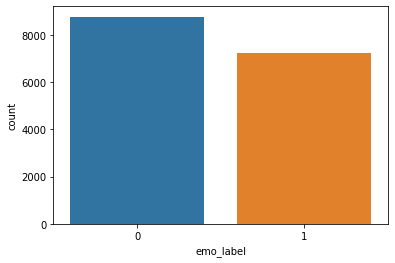

In [10]:
print(train_df.emo_label.value_counts())
sns.countplot(train_df.emo_label)

In [11]:
x_train, x_test, y_train, y_test = train_df["text_prep"], val_df["text_prep"], train_df["emo_label"], val_df["emo_label"]


In [12]:
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

In [13]:
dummy_y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [14]:
tokenizer = Tokenizer()

#Updates internal vocabulary based on a list of texts. 
#This method creates the vocabulary index based on word frequency. 
#it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).
tokenizer.fit_on_texts(x_train)

#Transforms each text in texts to a sequence of integers. Basically if you had a sentence, it would assign an integer to each word from your sentence.
#It basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
TEST = tokenizer.texts_to_sequences(test_df["text_prep"]) 

In [15]:
#maxlen: max length of one review for the training

lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 35


In [16]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
TEST = pad_sequences(TEST, padding='post', maxlen=maxlen)

In [17]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
EPOCHS= 30
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [18]:
# embedding matrix: list of all words and their corresponding embeddings.
#all the words which are not in the GloVe dictionary being assigned a zero vector.
embedding_index = {}
def get_embedding_vectors(tokenizer, dim=300):
#   embedding_index = {}
    with open('//Users//datdao//Downloads//glove.6B//glove.6B.300d.txt','r') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
          
    return embedding_matrix

In [19]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading GloVe: 400000it [00:45, 8842.89it/s] 


In [20]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen, trainable=False))
model.add(layers.Dropout(0.3)) 
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act)) 
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(2, activation="softmax"))
model.compile(optimizer=opt, loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

2021-11-02 10:14:26.285785: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 300)           3440100   
_________________________________________________________________
dropout (Dropout)            (None, 35, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 33, 32)            28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 32)             0

In [21]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=2,
    mode='min', restore_best_weights=True)

In [22]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=2, validation_data=(X_test, dummy_y_test), batch_size=128, callbacks=[early_stopping, model_checkpoint_callback], shuffle=True) 
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

2021-11-02 10:14:27.779805: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
125/125 - 55s - loss: 0.5675 - accuracy: 0.6974 - val_loss: 0.3626 - val_accuracy: 0.8420
Epoch 2/30
125/125 - 13s - loss: 0.4048 - accuracy: 0.8233 - val_loss: 0.2962 - val_accuracy: 0.8750
Epoch 3/30
125/125 - 9s - loss: 0.3574 - accuracy: 0.8458 - val_loss: 0.2789 - val_accuracy: 0.8860
Epoch 4/30
125/125 - 8s - loss: 0.3314 - accuracy: 0.8584 - val_loss: 0.2452 - val_accuracy: 0.9035
Epoch 5/30
125/125 - 8s - loss: 0.3064 - accuracy: 0.8726 - val_loss: 0.2282 - val_accuracy: 0.9120
Epoch 6/30
125/125 - 8s - loss: 0.2850 - accuracy: 0.8816 - val_loss: 0.2117 - val_accuracy: 0.9255
Epoch 7/30
125/125 - 8s - loss: 0.2752 - accuracy: 0.8826 - val_loss: 0.2135 - val_accuracy: 0.9220
Epoch 8/30
125/125 - 9s - loss: 0.2579 - accuracy: 0.8936 - val_loss: 0.1992 - val_accuracy: 0.9235
Epoch 9/30
125/125 - 10s - loss: 0.2541 - accuracy: 0.8937 - val_loss: 0.1963 - val_accuracy: 0.9255
Epoch 10/30
125/125 - 9s - loss: 0.2364 - accuracy: 0.9012 - val_loss: 0.1970 - val_accuracy: 0.9

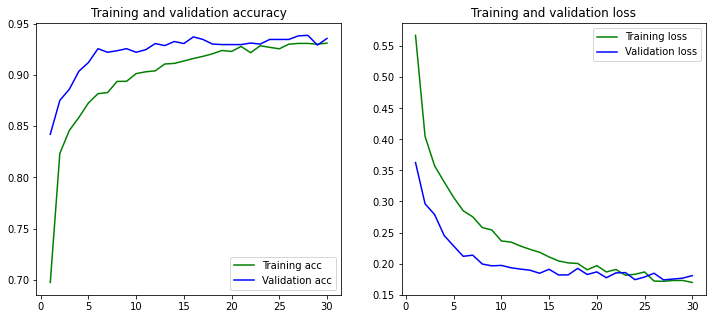

In [23]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
PlotGraph(history)

In [24]:
TEST_SENTIMENT = tokenizer.texts_to_sequences(test_df["text_prep"]) 
TEST_SENTIMENT = pad_sequences(TEST_SENTIMENT, padding='post', maxlen=maxlen)

predict = model.predict(TEST_SENTIMENT)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

array([0, 0, 0, ..., 1, 1, 0])

In [25]:
cm = confusion_matrix(test_df["emo_label"], predict_class)
cm

array([[1030,   50],
       [  84,  836]])

Text(69.0, 0.5, 'Predicted Class')

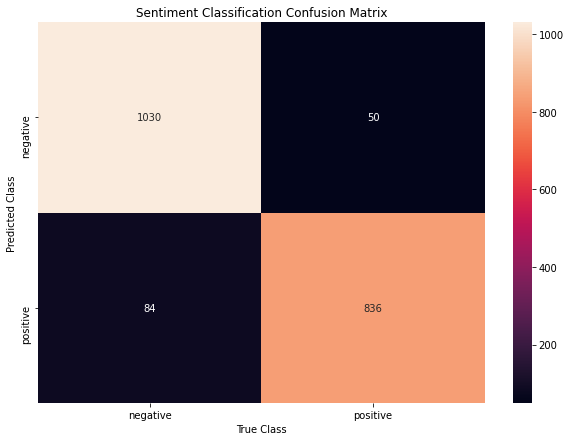

In [26]:
df_cm = pd.DataFrame(cm, index=["negative", "positive"], columns=["negative", "positive"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")
plt.title('Sentiment Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

In [27]:
print('\n###### classification report ######\n')
print(classification_report(test_df["emo_label"], predict_class, target_names =["negative", "positive"]))

print("Accuracy:", accuracy_score(test_df["emo_label"], predict_class))

print("Recall:", recall_score(test_df["emo_label"], predict_class, average='weighted'))

print("Precision:", precision_score(test_df["emo_label"], predict_class, average='weighted'))

print("F1-score:", f1_score(test_df["emo_label"], predict_class, average='weighted'))

print("ROC AUC score:",roc_auc_score(test_df["emo_label"], predict_class, average='weighted'))


###### classification report ######

              precision    recall  f1-score   support

    negative       0.92      0.95      0.94      1080
    positive       0.94      0.91      0.93       920

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

Accuracy: 0.933
Recall: 0.933
Precision: 0.933322499199598
F1-score: 0.932888467591569
ROC AUC score: 0.9311996779388083


<h2>Multinominal NB</h2>

In [28]:
cv = CountVectorizer(ngram_range=(1,2))
x_train = cv.fit_transform(train_df['text_prep'])
y_train = train_df['emo_label']
x_test = cv.transform(test_df['text_prep'])
y_test = test_df['emo_label']

In [29]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
# make prediction on testing data

y_pred_test_mnb = mnb.predict(x_test)
y_predprob_mnb = mnb.predict_proba(x_test)

Text(69.0, 0.5, 'Predicted Class')

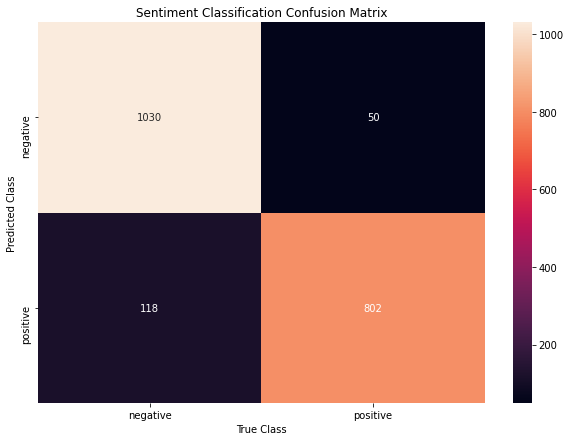

In [30]:
matrix = confusion_matrix(y_test,y_pred_test_mnb)
plt.figure(figsize = (10,7))
sns.heatmap(matrix,annot=True, fmt ="d", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.title('Sentiment Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

In [31]:
print('\n###### classification report ######\n')

print(classification_report(y_test, y_pred_test_mnb, target_names =["negative", "positive"]))

print("Accuracy:", accuracy_score(y_test, y_pred_test_mnb))

print("Recall:", recall_score(y_test, y_pred_test_mnb))

print("Precision:", precision_score(y_test, y_pred_test_mnb))

print("F1-score:", f1_score(y_test, y_pred_test_mnb))

print("ROC AUC score:",roc_auc_score(y_test, y_pred_test_mnb))


###### classification report ######

              precision    recall  f1-score   support

    negative       0.90      0.95      0.92      1080
    positive       0.94      0.87      0.91       920

    accuracy                           0.92      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.92      0.92      2000

Accuracy: 0.916
Recall: 0.8717391304347826
Precision: 0.9413145539906104
F1-score: 0.9051918735891648
ROC AUC score: 0.9127214170692431


In [32]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(cv.get_feature_names(), mnb.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


[('like', -4.992),
 ('not', -5.069),
 ('make', -5.857),
 ('get', -5.938),
 ('go', -6.047),
 ('love', -6.103),
 ('time', -6.156),
 ('really', -6.192),
 ('think', -6.217),
 ('know', -6.243)]

In [33]:
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('aa', -12.285),
 ('aa full', -12.285),
 ('aa meet', -12.285),
 ('aaaaand', -12.285),
 ('aaaaand another', -12.285),
 ('aac', -12.285),
 ('aac kind', -12.285),
 ('aaron', -12.285),
 ('aaron friend', -12.285),
 ('abandon angry', -12.285)]

<h2>Logistic Regression</h2>

In [34]:
x_train = cv.fit_transform(train_df['text_prep'])
y_train = train_df['emo_label']
x_test = cv.transform(test_df['text_prep'])
y_test = test_df['emo_label']

# fit a logistic regression classifier on the training data use default settings
lr = LogisticRegression()
lr.fit(x_train, y_train)

# make prediction on testing data
y_pred_test_lr = lr.predict(x_test)
y_predprob_lr = lr.predict_proba(x_test)


Text(69.0, 0.5, 'Predicted Class')

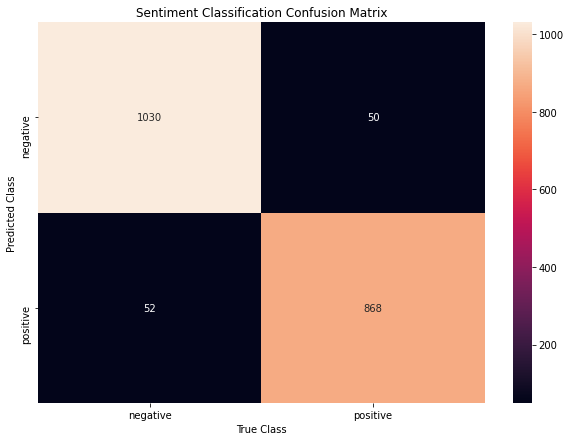

In [35]:
matrix_lr = confusion_matrix(y_test,y_pred_test_lr)
plt.figure(figsize = (10,7))
sns.heatmap(matrix_lr,annot=True, fmt ="d", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.title('Sentiment Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

In [36]:
print(classification_report(y_test, y_pred_test_lr, target_names =["negative", "positive"]))

print("Accuracy:", accuracy_score(y_test,y_pred_test_lr))

print("Recall:", recall_score(y_test,y_pred_test_lr))

print("Precision:", precision_score(y_test,y_pred_test_lr))

print("F1-score:", f1_score(y_test,y_pred_test_lr))

print("ROC AUC score:",roc_auc_score(y_test,y_pred_test_lr))

              precision    recall  f1-score   support

    negative       0.95      0.95      0.95      1080
    positive       0.95      0.94      0.94       920

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

Accuracy: 0.949
Recall: 0.9434782608695652
Precision: 0.9455337690631809
F1-score: 0.9445048966267682
ROC AUC score: 0.9485909822866345


In [37]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(cv.get_feature_names(), lr.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('passionate', 3.273),
 ('amaze', 3.168),
 ('sympathetic', 3.157),
 ('sweet', 3.044),
 ('generous', 3.038),
 ('daze', 3.034),
 ('resolve', 3.022),
 ('satisfy', 2.943),
 ('content', 2.899),
 ('innocent', 2.887)]

In [38]:
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]


Top negative features:


[('agitate', -2.966),
 ('hat', -2.75),
 ('reluctant', -2.75),
 ('uncertain', -2.693),
 ('torture', -2.618),
 ('ashamed', -2.6),
 ('resentful', -2.578),
 ('lethargic', -2.574),
 ('greedy', -2.554),
 ('dangerous', -2.494)]

<h2>SVM</h2>

In [39]:
x_train = cv.fit_transform(train_df['text_prep'])
y_train = train_df['emo_label']
x_test = cv.transform(test_df['text_prep'])
y_test = test_df['emo_label']


In [40]:
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')

classifier_linear.fit(x_train, y_train)

prediction_linear = classifier_linear.predict(x_test)


In [41]:
# results
report = classification_report(y_test, prediction_linear)
matrix_svm = confusion_matrix(y_test,prediction_linear)

Text(69.0, 0.5, 'Predicted Class')

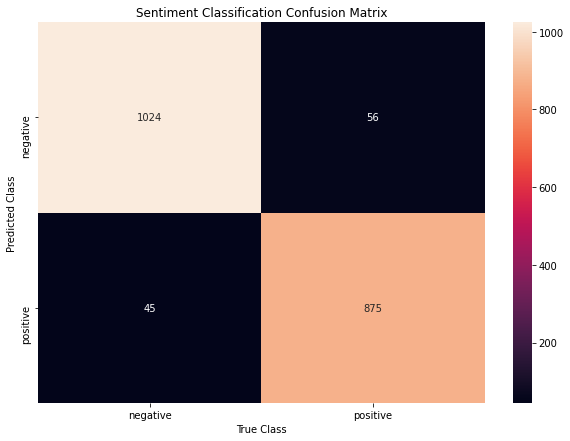

In [42]:
plt.figure(figsize = (10,7))
sns.heatmap(matrix_svm,annot=True, fmt ="d", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.title('Sentiment Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

In [43]:
print(report)

print("Accuracy:", accuracy_score(y_test, prediction_linear))

print("Recall:", recall_score(y_test, prediction_linear))

print("Precision:", precision_score(y_test, prediction_linear))

print("F1-score:", f1_score(y_test, prediction_linear))

print("ROC AUC score:",roc_auc_score(y_test, prediction_linear))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1080
           1       0.94      0.95      0.95       920

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

Accuracy: 0.9495
Recall: 0.9510869565217391
Precision: 0.9398496240601504
F1-score: 0.9454349000540248
ROC AUC score: 0.9496175523349437
